In [1]:
!pip install torchmetrics
!pip install pytorch_accelerated

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import argparse
from pathlib import Path

import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
import torchmetrics
from timm.scheduler import CosineLRScheduler

from pytorch_accelerated.callbacks import SaveBestModelCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS

import pickle
import os
from google.colab import drive

INFO:pytorch_accelerated:Setting random seeds


In [ ]:
# 1 load dataset from google drive

drive.mount('/content/drive')
# data_path = "/content/drive/MyDrive/mushrooms_dataset_cls10/Data"
data_split_drive_path = "/content/drive/MyDrive/mushrooms_dataset_cls10"
data_split_path = "/content/mushrooms_dataset_cls10"
data_path = "/content/"



Mounted at /content/drive


In [4]:
!ls drive/MyDrive/mushrooms_dataset_cls10/
!unzip /content/mushrooms_dataset_cls10.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: mushrooms_dataset_cls10/train/Russula/Russula_original_371_z74-gdAJbLY.jpg_bf00f526-5097-4f91-8f9b-a046ddaf2dfd.jpg  
  inflating: mushrooms_dataset_cls10/train/Russula/Russula_original_493_DO-koV24bD8.jpg_bfe92d83-4185-47e9-be30-b0cb1f31808d.jpg  
  inflating: mushrooms_dataset_cls10/train/Russula/Russula_original_154_M0Rd-PMmTLw.jpg_32b8bd7d-9d9d-4bee-9c6d-75d44eb0ea5d.jpg  
  inflating: mushrooms_dataset_cls10/train/Russula/Russula_original_075_jDJG-vbxuaY.jpg_3f003b00-aa14-4cdc-b4fc-db0f00aba3bc.jpg  
  inflating: mushrooms_dataset_cls10/train/Russula/Russula_original_064_TmjEba6Ko4Y.jpg_7fae13e0-d1c7-4798-ac96-e6ade2533a1b.jpg  
  inflating: mushrooms_dataset_cls10/train/Russula/Russula_original_313_jSUE5jmsXeY.jpg_001d1de3-f0e5-4411-9bb1-68ef894daac7.jpg  
  inflating: mushrooms_dataset_cls10/train/Russula/Russula_original_212__ofqr2CDl2A.jpg_c3a069a3-0d76-4696-ad68-c28daa1e7cb9.jpg  
  inflating: mushrooms_dataset_cls10/train/Russula/Russu

In [ ]:
# #  2.0 diplay image number distribute of each class(制作数据已经完成，此部跳过)
# import matplotlib.pyplot as plt

# data_path = os.path.join(data_split_path, 'train')
# class_list = os.listdir(data_path)
# # data_path = os.path.join(root_dir, "data")

# data_cls_path = os.path.join(data_split_path, "classes_list.txt")
# cls_cnt = {}
# with open(data_cls_path, "w") as f:
#   for sub_dir in os.listdir(data_path):
#     sub_abs_dir = os.path.join(data_path, sub_dir)
#     if os.path.isdir(sub_abs_dir):
#       image_count = len([f for f in os.listdir(sub_abs_dir) if f.lower().endswith(".jpg")])
#       text_line = f"{sub_dir} {image_count}"
#       f.write(text_line + "\n")
#       cls_cnt['sub_dir'] = image_count

# plt.figure(figsize=(10, 6))
# plt.bar(cls_cnt.keys(), cls_cnt.values(), color='skyblue')
# plt.xlabel("Class")
# plt.ylabel("Number of Images")
# plt.title("Image Count per Class")
# plt.grid(axis='y', linestyle="--", alpha=0.7)
# plt.show()

# print(f"min: {min(cls_cnt.values())}, max: {max(cls_cnt.values())}")


In [ ]:
# #  3.0 split images to train, test(制作数据已经完成，此部跳过)
# import random
# import shutil

# train_path = os.path.join(data_split_path, "train")
# test_path = os.path.join(data_split_path, "val")
# os.makedirs(train_path, exist_ok=True)
# os.makedirs(test_path, exist_ok=True)
# # root_dir = os.path.join(data_root_dir, "mushrooms_dataset")
# # data_path = os.path.join(root_dir, "data")
# train_ratio = 0.8
# # iterate all datasets
# for class_name in os.listdir(data_path):
#     class_dir = os.path.join(data_path, class_name)

#     if os.path.isdir(class_dir):  # only choose directory
#         images = [f for f in os.listdir(class_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
#         random.shuffle(images)  # shuffle

#         # split dataset
#         split_idx = int(len(images) * train_ratio)
#         train_images = images[:split_idx]
#         test_images = images[split_idx:]

#         # create sub classes
#         os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
#         os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

#         # copy image to train, train directory
#         for img in train_images:
#             src = os.path.join(class_dir, img)
#             dst = os.path.join(train_path, class_name, img)
#             shutil.copy(src, dst)

#         # copy image to val directory
#         for img in test_images:
#             src = os.path.join(class_dir, img)
#             dst = os.path.join(test_path, class_name, img)
#             shutil.copy(src, dst)

#         print(f"Class: {class_name}, Train: {len(train_images)}, Val: {len(test_images)}")

# print("finish dataset split！")

In [ ]:
#4. print class name list and image number of each class, and creatlabel classname map
label_classname_map = {}
classname_label_map = {}
label_edible_map = {}
label_id = 0
with open(os.path.join(data_split_drive_path, 'classes_list2.txt'), 'r') as f:
  for line in f.readlines():
    line = line.strip()
    # print(line)
    cls_nm, cls_cnt, cls_edible = line.split(" ")
    label_classname_map[label_id] = cls_nm
    classname_label_map[cls_nm] = label_id
    label_edible_map[label_id] = cls_edible
    label_id += 1

print(label_classname_map)
print(classname_label_map)

{0: 'Agaricus', 1: 'Amanita', 2: 'Boletus', 3: 'Cortinarius', 4: 'Entoloma', 5: 'Exidia', 6: 'Hygrocybe', 7: 'Inocybe', 8: 'Lactarius', 9: 'Pluteus', 10: 'Russula', 11: 'Suillus'}
{'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Exidia': 5, 'Hygrocybe': 6, 'Inocybe': 7, 'Lactarius': 8, 'Pluteus': 9, 'Russula': 10, 'Suillus': 11}


In [ ]:
# !ls drive/MyDrive/mushrooms_dataset_cls10/
# !unzip /content/mushrooms_dataset_cls10.zip

In [ ]:

def create_datasets(image_size, data_mean, data_std, train_path, val_path, label_parser):
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )

    train_dataset = timm.data.dataset.ImageDataset(train_path, transform=train_transforms, class_map=label_parser)
    eval_dataset = timm.data.dataset.ImageDataset(val_path, transform=eval_transforms, class_map=label_parser)

    return train_dataset, eval_dataset


In [ ]:
class TimmMixupTrainer(Trainer):
    def __init__(self, eval_loss_fn, mixup_args, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        # self.train_loss_fn = kwargs['loss_func']
        self.num_updates = None
        self.mixup_fn = timm.data.Mixup(**mixup_args)

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.ema_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.train_loss_metric = torchmetrics.MeanMetric()
        self.val_loss_metric = torchmetrics.MeanMetric()
        self.ema_model = None

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1,
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9)
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch):
        xb, yb = batch
        # mixup_xb, mixup_yb = self.mixup_fn(xb, yb)

        # train_loss = super().calculate_train_batch_loss((mixup_xb, mixup_yb))
        train_loss = super().calculate_train_batch_loss((xb, yb))
        # print("train_loss['loss']:{}, yb:{}".format(train_loss['loss'], yb.shape))
        self.train_loss_metric.update(train_loss['loss'])

        return train_loss
        # return super().calculate_train_batch_loss((mixup_xb, mixup_yb))

    def train_epoch_end(
        self,):
        self.ema_model.update(self.model)
        self.ema_model.eval()

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)

            # val_loss = super().calculate_train_batch_loss((outputs, yb))
            # print("val_loss['loss']:{}".format(val_loss['loss']))
            val_loss = self.eval_loss_fn(outputs, yb)
            # print('val_loss: {}, yb:{}'.format(val_loss, yb.shape))
            self.val_loss_metric.update(val_loss)
            self.accuracy.update(outputs.argmax(-1), yb)

            ema_model_preds = self.ema_model.module(xb).argmax(-1)
            self.ema_accuracy.update(ema_model_preds, yb)

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric("ema_model_accuracy", self.ema_accuracy.compute().cpu())
        self.run_history.update_metric("train_loss_metric", self.train_loss_metric.compute().cpu())
        self.run_history.update_metric("val_loss_metric", self.val_loss_metric.compute().cpu())
        self.accuracy.reset()
        self.ema_accuracy.reset()
        self.train_loss_metric.reset()
        self.val_loss_metric.reset()


In [ ]:
# # Set training arguments, hardcoded here for clarity (训练完成，不用重新训练)
# image_size = (256, 256)
# lr = 5e-3
# smoothing = 0.1
# mixup = 0.0
# cutmix = 0.0
# batch_size = 32
# bce_target_thresh = 0.2
# num_epochs = 50
# # num_epochs = 1

# # data_path = "/content/"
# train_path = os.path.join(data_split_path, "train")
# val_path = os.path.join(data_split_path, "val")

# class_names = sorted([f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))])
# assert class_names == sorted([f for f in os.listdir(val_path) if os.path.isdir(os.path.join(val_path, f))])
# class_to_idx = classname_label_map
# id_to_class = label_classname_map
# num_classes = len(label_classname_map.keys())

# print("num_classes: {}, len classes:{}".format(num_classes, len(class_names)))


# mixup_args = dict(
#     # mixup_alpha=mixup,
#     # cutmix_alpha=cutmix,
#     label_smoothing=smoothing,
#     num_classes=num_classes,
# )
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# # Create model using timm
# model = timm.create_model(
#     "resnet50d", pretrained=True, num_classes=num_classes, drop_path_rate=0.05
# )
# model = model.to(device)

# # Load data config associated with the model to use in data augmentation pipeline
# data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
# data_mean = data_config["mean"]
# data_std = data_config["std"]

# # Create training and validation datasets
# train_dataset, eval_dataset = create_datasets(
#     train_path=train_path,
#     val_path=val_path,
#     image_size=image_size,
#     data_mean=data_mean,
#     data_std=data_std,
#     label_parser=class_to_idx,
# )

# # Create optimizer
# optimizer = timm.optim.create_optimizer_v2(
#     model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
# )

# # As we are using Mixup, we can use BCE during training and CE for evaluation
# # train_loss_fn = timm.loss.BinaryCrossEntropy(
# #     target_threshold=bce_target_thresh, smoothing=smoothing
# # )

# train_loss_fn = torch.nn.CrossEntropyLoss()
# validate_loss_fn = torch.nn.CrossEntropyLoss()

# # Create trainer and start training
# trainer = TimmMixupTrainer(
#     model=model,
#     optimizer=optimizer,
#     loss_func=train_loss_fn,
#     eval_loss_fn=validate_loss_fn,
#     mixup_args=mixup_args,
#     num_classes=num_classes,
#     callbacks=[
#         *DEFAULT_CALLBACKS,
#         SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
#     ],
# )

# trainer.train(
#     per_device_batch_size=batch_size,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     num_epochs=num_epochs,
#     create_scheduler_fn=trainer.create_scheduler,
# )

# torch.save(model.state_dict(), 'last_model_weights.pth')

# def save_history():
#   history = {}
#   for key in trainer.run_history.get_metric_names():
#     history[key] = trainer.run_history.get_metric_values(key)

#   with open('/content/run_history.pkl', 'wb') as f:
#     pickle.dump(history, f)

# save_history()

# ## move temp file to google drive
# !cp /content/run_history.pkl /content/drive/MyDrive/mushrooms_dataset_cls10/run_history.pkl

# #  save model file to google drive
# torch.save(model.state_dict(), 'last_model_weights.pth')
# torch.save(model.state_dict(), 'model_weights.pth')
# # !mkdir /content/drive/MyDrive/mushrooms_dataset_cls10/pretrainedmodel/
# !cp /content/last_model_weights.pth /content/drive/MyDrive/mushrooms_dataset_cls10/pretrainedmodel/
# !cp /content/model_weights.pth /content/drive/MyDrive/mushrooms_dataset_cls10/pretrainedmodel/



dict_keys(['ema_model_accuracy', 'train_loss_metric', 'val_loss_metric', 'eval_loss_epoch', 'train_loss_epoch', 'accuracy'])
[tensor(2.0962), tensor(1.8843), tensor(1.7442), tensor(1.5798), tensor(1.4801), tensor(1.4069), tensor(1.3316), tensor(1.2850), tensor(1.2604), tensor(1.1789), tensor(1.1337), tensor(1.0822), tensor(1.0487), tensor(1.0072), tensor(0.9691), tensor(0.9322), tensor(0.8940), tensor(0.8542), tensor(0.8228), tensor(0.7862), tensor(0.7626), tensor(0.7071), tensor(0.6932), tensor(0.6418), tensor(0.6193), tensor(0.5953), tensor(0.5739), tensor(0.5315), tensor(0.5127), tensor(0.4928), tensor(0.4782), tensor(0.4487), tensor(0.4319), tensor(0.4149), tensor(0.3978), tensor(0.3842), tensor(0.3570), tensor(0.3514), tensor(0.3382), tensor(0.3271), tensor(0.3198), tensor(0.3186), tensor(0.3006), tensor(0.2922), tensor(0.2775), tensor(0.2908), tensor(0.2878), tensor(0.2822), tensor(0.2836), tensor(0.2717)]
[1.3352913856506348, 1.2448031902313232, 1.2795491218566895, 1.08969783782

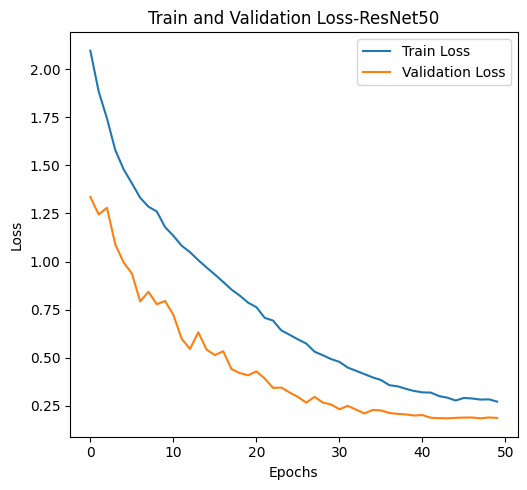

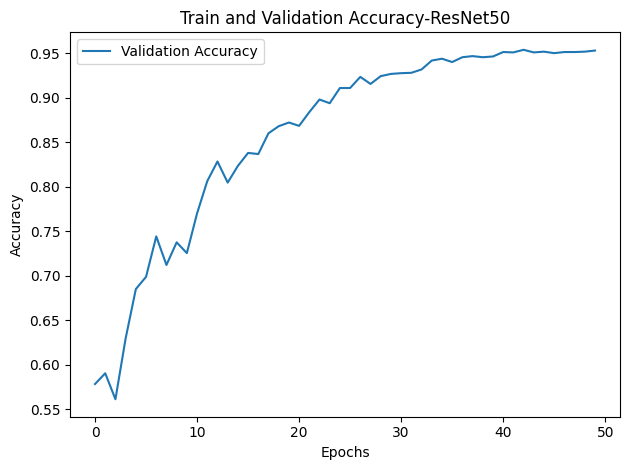

In [ ]:
import matplotlib.pyplot as plt

with open('/content/drive/MyDrive/mushrooms_dataset_cls10/run_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)
# Plotting train and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# print(dir(trainer.run_history))
print(loaded_history.keys())
print(loaded_history['train_loss_metric'])
print(loaded_history['eval_loss_epoch'])

# with open('/content/run_history.pkl', 'rb') as f:
#   loaded_history = pickle.load(f)

plt.plot(loaded_history['train_loss_metric'], label="Train Loss")
plt.plot(loaded_history['eval_loss_epoch'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss-ResNet50")
plt.legend()
plt.tight_layout()
plt.show()

# Plotting train and validation accuracy
plt.subplot(1, 1, 1)
plt.plot(loaded_history['accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy-ResNet50")
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/103M [00:00<?, ?B/s]

num_classes: 12, len classes:12


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


final_accuracy: 0.0000
Confusion Matrix:
 [[193   0   0   0   1   0   2   1   1   0   1   1]
 [  1 192   0   1   1   0   0   0   3   0   2   0]
 [  0   0 191   1   0   0   0   0   2   0   1   5]
 [  2   0   1 187   0   0   1   0   3   1   3   2]
 [  1   5   0   1 178   1   2   8   0   2   2   0]
 [  1   0   0   0   0 198   0   0   0   1   0   0]
 [  0   1   0   0   3   0 194   1   0   1   0   0]
 [  3   0   0   0   2   0   0 191   1   3   0   0]
 [  0   1   1   0   3   1   0   0 191   0   3   0]
 [  0   0   0   1   1   0   1   1   0 195   1   0]
 [  1   2   0   2   0   0   0   1   1   2 190   1]
 [  2   1   2   3   0   0   0   1   2   0   0 189]]
F1 Score: 0.9537
Recall: 0.9537
Precision: 0.9539
Accuracy: 0.9537


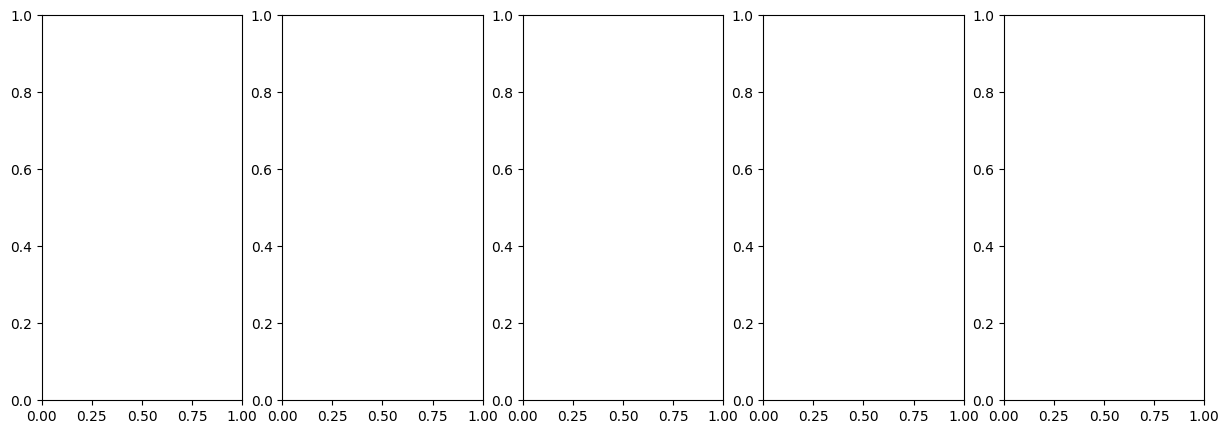

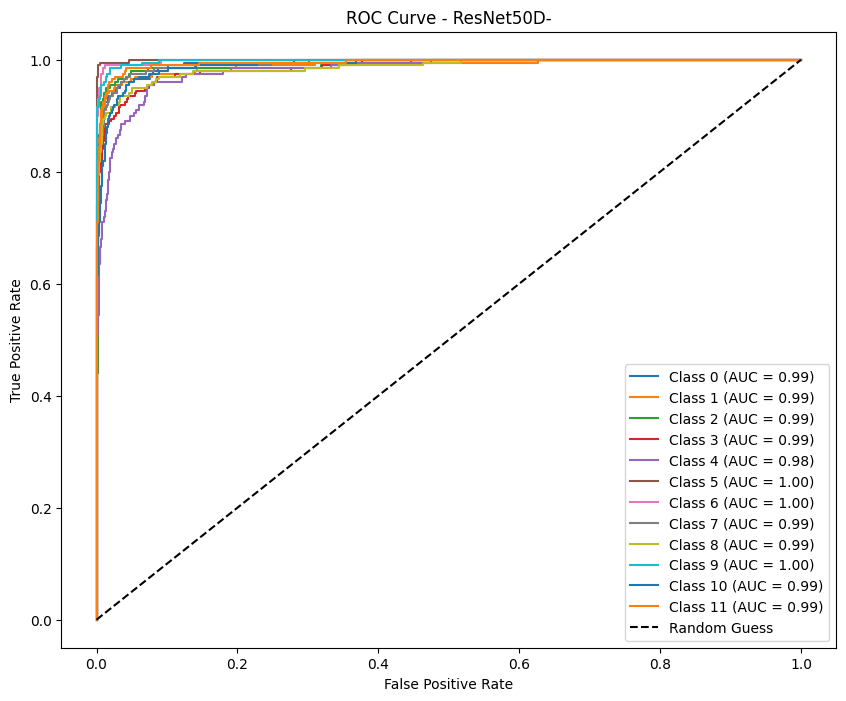

In [ ]:
import torchmetrics
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

def create_eval_datasets(image_size, data_mean, data_std, val_path, label_parser):
    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )
    eval_dataset = timm.data.dataset.ImageDataset(val_path, transform=eval_transforms, class_map=label_parser)

    return eval_dataset

# Define a function to calculate and print all the metrics
def evaluate_model(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # F1 score
    recall = recall_score(y_test, y_pred, average='weighted')  # Recall
    precision = precision_score(y_test, y_pred, average='weighted')  # Precision
    accuracy = accuracy_score(y_test, y_pred)  # Accuracy

    print("Confusion Matrix:\n", cm)
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    return cm


def plot_roc(y_test, y_pred, num_classes, model_name):
  lb = LabelBinarizer()
  plt.figure(figsize=(10, 8))
  # Plot ROC curve for each class
  encoder = OneHotEncoder(sparse_output=False)
  y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1))
  y_pred = encoder.fit_transform(np.array(y_pred).reshape(-1, 1))

  y_test_bin = lb.fit_transform(y_test)
  n_classes = y_pred.shape[1]
  for i in range(n_classes):
      fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, lw=2, label=f'{model_name} - Class {i} (AUC = {roc_auc:.2f})')

def plot_roc2(y_test, y_pred, num_classes, model_name, desc=""):
    plt.figure(figsize=(10, 8))

    encoder = OneHotEncoder(sparse_output=False)
    if y_test.ndim == 1 or y_test.shape[1] == 1:
        one_hot_y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1))
    else:
        one_hot_y_test = y_test

    if y_pred.ndim == 1 or y_pred.shape[1] == 1:
        one_hot_y_pred = encoder.transform(np.array(y_pred).reshape(-1, 1))
    else:
        one_hot_y_pred = y_pred

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(one_hot_y_test[:, i], one_hot_y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}-{desc}")
    plt.legend(loc="lower right")
    plt.show()



#  dataset init
train_path = os.path.join(data_split_drive_path, "train")
val_path = os.path.join(data_split_drive_path, "val")
class_names = sorted([f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))])
assert class_names == sorted([f for f in os.listdir(val_path) if os.path.isdir(os.path.join(val_path, f))])
num_classes = len(class_names)

## init eval model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_eval = timm.create_model('resnet50', pretrained=False, num_classes=10)
model_eval = timm.create_model(
    "resnet50d", pretrained=True, num_classes=num_classes, drop_path_rate=0.05)
model_eval = model_eval.to(device)

model_eval.load_state_dict(torch.load('/content/drive/MyDrive/mushrooms_dataset_cls10/pretrainedmodel/last_model_weights.pth',map_location=device))
# model_eval.load_state_dict(torch.load('/content/best_model.pt'))
model_eval.eval()

# creat data config
data_config = timm.data.resolve_data_config({}, model=model_eval, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]
image_size = (256, 256)
# Create training and validation datasets
eval_dataset = create_eval_datasets(
    val_path=val_path,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
    label_parser=classname_label_map,
)


print("num_classes: {}, len classes:{}".format(num_classes, len(class_names)))
diplay_pic_num = 5
pic_sample_freq = 2
show_id = 0
fig, axes = plt.subplots(1, diplay_pic_num, figsize=(15, 5))
plt.ion()

accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

y_labels = []
pre_labels = []
pred_probs = []
evaYLabel = "y_labels.npy"
evaPreLabel = "pre_labels.npy"
evaPreProb = "pred_probs.npy"
if not os.path.exists(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaYLabel)):
  with torch.no_grad():
      # for idx, cur_eval_data in enumerate(eval_dataset):
      for idx, cur_eval_data in tqdm(enumerate(eval_dataset), total=len(eval_dataset), desc="Evaluating"):
          # print("image: {}, label :{}".format(images.size(), labels))
          images, labels_orig = cur_eval_data
          label_classname = eval_dataset.filenames()[idx].split("/")[0].split("Tomato___")[-1]
          labels = torch.tensor(labels_orig).to(device)
          images, labels = images.to(device), torch.tensor(labels).to(device)
          images = images.unsqueeze(0)

          outputs = model_eval(images)
          labels = labels.to(torch.int64).reshape(1)

          accuracy_metric.update(outputs.argmax(-1), labels)
          y_labels.append(labels.cpu().item())
          pre_labels.append(outputs.argmax(-1).cpu().item())
          pred_prob = outputs.squeeze().cpu().numpy()
          pred_probs.append(pred_prob)

          ###### visual sample data
          if idx%pic_sample_freq == 0 and show_id<diplay_pic_num:
            image_tmp = Image.open(os.path.join(val_path, eval_dataset.filenames()[idx]))
            axes[show_id].imshow(image_tmp)
            axes[show_id].set_title(f"Pred: {label_classname_map[outputs.argmax(-1).cpu()[0].item()]} \
            \n edible:{label_edible_map[outputs.argmax(-1).cpu()[0].item()]}")
            axes[show_id].axis('off')
            show_id += 1
          if show_id == diplay_pic_num:
            plt.show()
          ##### print("label id:{}, label name: {}, id_map:{}, pred:{}".format(labels_orig, label_classname, id_to_class[labels_orig], outputs.argmax(-1).cpu()[0]))
  #save result to google drive
  with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaYLabel), 'wb') as f:
    np.save(f, np.array(y_labels))
  with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaPreLabel), 'wb') as f:
    np.save(f, np.array(pre_labels))
  with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaPreProb), 'wb') as f:
    np.save(f, np.array(pred_probs))
else:
    with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaYLabel), 'rb') as f:
      y_labels = np.load(f)
    with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaPreLabel), 'rb') as f:
      pre_labels = np.load(f)
    with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaPreProb), 'rb') as f:
      pred_probs = np.load(f)

# caculate accuracy
final_accuracy = accuracy_metric.compute()
print(f"final_accuracy: {final_accuracy:.4f}")
evaluate_model(y_labels, pre_labels)
# plot_roc(y_labels, pre_labels, num_classes, 'mushroom_classification')
plot_roc2(np.array(y_labels), np.array(pred_probs), num_classes, "ResNet50D", desc="")

In [ ]:
# Set training arguments, hardcoded here for clarity (训练完成，不用重新训练)
image_size = (256, 256)
lr = 5e-5
smoothing = 0.1
mixup = 0.0
cutmix = 0.0
batch_size = 32
bce_target_thresh = 0.2
num_epochs = 50
# num_epochs = 1

# data_path = "/content/"
train_path = os.path.join(data_split_path, "train")
val_path = os.path.join(data_split_path, "val")

class_names = sorted([f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))])
assert class_names == sorted([f for f in os.listdir(val_path) if os.path.isdir(os.path.join(val_path, f))])
class_to_idx = classname_label_map
id_to_class = label_classname_map
num_classes = len(label_classname_map.keys())

print("num_classes: {}, len classes:{}".format(num_classes, len(class_names)))


mixup_args = dict(
    # mixup_alpha=mixup,
    # cutmix_alpha=cutmix,
    label_smoothing=smoothing,
    num_classes=num_classes,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create model using timm
model = timm.create_model(
    "vgg16", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]

# Create training and validation datasets
train_dataset, eval_dataset = create_datasets(
    train_path=train_path,
    val_path=val_path,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
    label_parser=class_to_idx,
)

# Create optimizer
optimizer = timm.optim.create_optimizer_v2(
    model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
)

# As we are using Mixup, we can use BCE during training and CE for evaluation
# train_loss_fn = timm.loss.BinaryCrossEntropy(
#     target_threshold=bce_target_thresh, smoothing=smoothing
# )

train_loss_fn = torch.nn.CrossEntropyLoss()
validate_loss_fn = torch.nn.CrossEntropyLoss()

# Create trainer and start training
trainer = TimmMixupTrainer(
    model=model,
    optimizer=optimizer,
    loss_func=train_loss_fn,
    eval_loss_fn=validate_loss_fn,
    mixup_args=mixup_args,
    num_classes=num_classes,
    callbacks=[
        *DEFAULT_CALLBACKS,
        SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
    ],
)

trainer.train(
    per_device_batch_size=batch_size,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    num_epochs=num_epochs,
    create_scheduler_fn=trainer.create_scheduler,
)

torch.save(model.state_dict(), 'vgg16_last_model_weights.pth')

def save_history():
  history = {}
  for key in trainer.run_history.get_metric_names():
    history[key] = trainer.run_history.get_metric_values(key)

  with open('/content/vgg16_run_history.pkl', 'wb') as f:
    pickle.dump(history, f)

save_history()

## move temp file to google drive
!cp /content/vgg16_run_history.pkl /content/drive/MyDrive/mushrooms_dataset_cls10/vgg16_run_history.pkl

#  save model file to google drive
torch.save(model.state_dict(), 'vgg16_last_model_weights.pth')
!cp /content/vgg16_last_model_weights.pth /content/drive/MyDrive/mushrooms_dataset_cls10/pretrainedmodel/vgg16_last_model_weights.pth


num_classes: 12, len classes:12


model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]


Starting training run

Starting epoch 1


100%|██████████| 300/300 [00:29<00:00, 10.05it/s]



train_loss_epoch: 1.8240891695022583

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 15.76it/s]



ema_model_accuracy: 0.15416666865348816

eval_loss_epoch: 1.0725057125091553

val_loss_metric: 1.0725058317184448

accuracy: 0.6274999976158142

Starting epoch 2


100%|██████████| 300/300 [00:28<00:00, 10.37it/s]



train_loss_metric: 1.8240894079208374

train_loss_epoch: 1.4000788927078247

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.70it/s]



ema_model_accuracy: 0.289166659116745

eval_loss_epoch: 0.860992431640625

val_loss_metric: 0.860992431640625

accuracy: 0.7137500047683716

Starting epoch 3


100%|██████████| 300/300 [00:28<00:00, 10.37it/s]



train_loss_metric: 1.4000788927078247

train_loss_epoch: 1.2241920232772827

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.44it/s]



ema_model_accuracy: 0.43041667342185974

eval_loss_epoch: 0.7115171551704407

val_loss_metric: 0.7115170955657959

accuracy: 0.768750011920929

Starting epoch 4


100%|██████████| 300/300 [00:28<00:00, 10.36it/s]



train_loss_metric: 1.2241922616958618

train_loss_epoch: 1.1192580461502075

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.34it/s]



ema_model_accuracy: 0.5258333086967468

eval_loss_epoch: 0.6410537958145142

val_loss_metric: 0.6410537958145142

accuracy: 0.79666668176651

Starting epoch 5


100%|██████████| 300/300 [00:28<00:00, 10.38it/s]



train_loss_metric: 1.119258165359497

train_loss_epoch: 1.0487675666809082

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.49it/s]



ema_model_accuracy: 0.6012499928474426

eval_loss_epoch: 0.5931647419929504

val_loss_metric: 0.5931648015975952

accuracy: 0.8100000023841858

Starting epoch 6


100%|██████████| 300/300 [00:28<00:00, 10.38it/s]



train_loss_metric: 1.0487674474716187

train_loss_epoch: 0.9637095332145691

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.37it/s]



ema_model_accuracy: 0.6583333611488342

eval_loss_epoch: 0.5217195153236389

val_loss_metric: 0.5217195153236389

accuracy: 0.8374999761581421

Starting epoch 7


100%|██████████| 300/300 [00:28<00:00, 10.38it/s]



train_loss_metric: 0.9637095928192139

train_loss_epoch: 0.9182061553001404

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.25it/s]



ema_model_accuracy: 0.7170833349227905

eval_loss_epoch: 0.48031651973724365

val_loss_metric: 0.48031651973724365

accuracy: 0.8445833325386047

Starting epoch 8


100%|██████████| 300/300 [00:28<00:00, 10.40it/s]



train_loss_metric: 0.9182063937187195

train_loss_epoch: 0.8843333721160889

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.28it/s]



ema_model_accuracy: 0.7591666579246521

eval_loss_epoch: 0.5120465755462646

val_loss_metric: 0.5120465755462646

accuracy: 0.8424999713897705

Starting epoch 9


100%|██████████| 300/300 [00:28<00:00, 10.39it/s]



train_loss_metric: 0.8843333721160889

train_loss_epoch: 0.8404091596603394

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.39it/s]



ema_model_accuracy: 0.7862499952316284

eval_loss_epoch: 0.43751129508018494

val_loss_metric: 0.43751123547554016

accuracy: 0.8645833134651184

Starting epoch 10


100%|██████████| 300/300 [00:28<00:00, 10.42it/s]



train_loss_metric: 0.8404091000556946

train_loss_epoch: 0.8104756474494934

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.47it/s]



ema_model_accuracy: 0.8066666722297668

eval_loss_epoch: 0.41564711928367615

val_loss_metric: 0.41564705967903137

accuracy: 0.8670833110809326

Starting epoch 11


100%|██████████| 300/300 [00:28<00:00, 10.40it/s]



train_loss_metric: 0.8104757070541382

train_loss_epoch: 0.76315838098526

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.34it/s]



ema_model_accuracy: 0.8208333253860474

eval_loss_epoch: 0.4482578635215759

val_loss_metric: 0.4482578933238983

accuracy: 0.8587499856948853

Starting epoch 12


100%|██████████| 300/300 [00:28<00:00, 10.41it/s]



train_loss_metric: 0.7631585597991943

train_loss_epoch: 0.7265474200248718

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.61it/s]



ema_model_accuracy: 0.840416669845581

eval_loss_epoch: 0.43211421370506287

val_loss_metric: 0.4321140944957733

accuracy: 0.878333330154419

Starting epoch 13


100%|██████████| 300/300 [00:28<00:00, 10.38it/s]



train_loss_metric: 0.7265471816062927

train_loss_epoch: 0.7115615606307983

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.41it/s]



ema_model_accuracy: 0.8541666865348816

eval_loss_epoch: 0.3587300479412079

val_loss_metric: 0.3587300479412079

accuracy: 0.8958333134651184

Starting epoch 14


100%|██████████| 300/300 [00:28<00:00, 10.40it/s]



train_loss_metric: 0.7115616798400879

train_loss_epoch: 0.6895946860313416

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.44it/s]



ema_model_accuracy: 0.8687499761581421

eval_loss_epoch: 0.39913082122802734

val_loss_metric: 0.39913082122802734

accuracy: 0.89083331823349

Starting epoch 15


100%|██████████| 300/300 [00:28<00:00, 10.39it/s]



train_loss_metric: 0.6895946264266968

train_loss_epoch: 0.6604838967323303

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.54it/s]



ema_model_accuracy: 0.8799999952316284

eval_loss_epoch: 0.3876429796218872

val_loss_metric: 0.387643039226532

accuracy: 0.9012500047683716

Starting epoch 16


100%|██████████| 300/300 [00:28<00:00, 10.41it/s]



train_loss_metric: 0.6604837775230408

train_loss_epoch: 0.6399854421615601

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.56it/s]



ema_model_accuracy: 0.8870833516120911

eval_loss_epoch: 0.3774997591972351

val_loss_metric: 0.3774997889995575

accuracy: 0.8941666483879089

Starting epoch 17


100%|██████████| 300/300 [00:28<00:00, 10.40it/s]



train_loss_metric: 0.6399855017662048

train_loss_epoch: 0.6050416827201843

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.37it/s]



ema_model_accuracy: 0.8941666483879089

eval_loss_epoch: 0.3711107671260834

val_loss_metric: 0.3711107671260834

accuracy: 0.8920833468437195

Starting epoch 18


100%|██████████| 300/300 [00:28<00:00, 10.41it/s]



train_loss_metric: 0.6050416827201843

train_loss_epoch: 0.5865506529808044

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.36it/s]



ema_model_accuracy: 0.8987500071525574

eval_loss_epoch: 0.33677786588668823

val_loss_metric: 0.33677786588668823

accuracy: 0.9125000238418579

Starting epoch 19


100%|██████████| 300/300 [00:28<00:00, 10.39it/s]



train_loss_metric: 0.5865505933761597

train_loss_epoch: 0.5823370218276978

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.21it/s]



ema_model_accuracy: 0.9058333039283752

eval_loss_epoch: 0.34029605984687805

val_loss_metric: 0.34029605984687805

accuracy: 0.9100000262260437

Starting epoch 20


100%|██████████| 300/300 [00:28<00:00, 10.39it/s]



train_loss_metric: 0.582336962223053

train_loss_epoch: 0.5687050223350525

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.09it/s]



ema_model_accuracy: 0.9087499976158142

eval_loss_epoch: 0.3260118067264557

val_loss_metric: 0.3260118067264557

accuracy: 0.903333306312561

Starting epoch 21


100%|██████████| 300/300 [00:28<00:00, 10.38it/s]



train_loss_metric: 0.5687049627304077

train_loss_epoch: 0.5509128570556641

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.19it/s]



ema_model_accuracy: 0.9104166626930237

eval_loss_epoch: 0.3316138684749603

val_loss_metric: 0.3316139280796051

accuracy: 0.909166693687439

Starting epoch 22


100%|██████████| 300/300 [00:28<00:00, 10.38it/s]



train_loss_metric: 0.5509131550788879

train_loss_epoch: 0.5297125577926636

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.55it/s]



ema_model_accuracy: 0.9125000238418579

eval_loss_epoch: 0.32388055324554443

val_loss_metric: 0.3238806128501892

accuracy: 0.9083333611488342

Starting epoch 23


100%|██████████| 300/300 [00:28<00:00, 10.39it/s]



train_loss_metric: 0.5297126173973083

train_loss_epoch: 0.5178349018096924

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.31it/s]



ema_model_accuracy: 0.918749988079071

eval_loss_epoch: 0.30684947967529297

val_loss_metric: 0.30684947967529297

accuracy: 0.9145833253860474

Starting epoch 24


100%|██████████| 300/300 [00:28<00:00, 10.41it/s]



train_loss_metric: 0.5178350210189819

train_loss_epoch: 0.4947139620780945

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.49it/s]



ema_model_accuracy: 0.9200000166893005

eval_loss_epoch: 0.329647034406662

val_loss_metric: 0.329647034406662

accuracy: 0.9116666913032532

Starting epoch 25


100%|██████████| 300/300 [00:28<00:00, 10.40it/s]



train_loss_metric: 0.49471405148506165

train_loss_epoch: 0.49042242765426636

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.29it/s]



ema_model_accuracy: 0.9200000166893005

eval_loss_epoch: 0.30366280674934387

val_loss_metric: 0.30366280674934387

accuracy: 0.9183333516120911

Starting epoch 26


100%|██████████| 300/300 [00:28<00:00, 10.39it/s]



train_loss_metric: 0.4904223680496216

train_loss_epoch: 0.47689956426620483

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.18it/s]



ema_model_accuracy: 0.9195833206176758

eval_loss_epoch: 0.3349604308605194

val_loss_metric: 0.33496034145355225

accuracy: 0.9137499928474426

Starting epoch 27


100%|██████████| 300/300 [00:28<00:00, 10.43it/s]



train_loss_metric: 0.4768996238708496

train_loss_epoch: 0.45184406638145447

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.42it/s]



ema_model_accuracy: 0.9212499856948853

eval_loss_epoch: 0.34721875190734863

val_loss_metric: 0.34721869230270386

accuracy: 0.9150000214576721

Starting epoch 28


100%|██████████| 300/300 [00:28<00:00, 10.43it/s]



train_loss_metric: 0.45184406638145447

train_loss_epoch: 0.4557022750377655

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.44it/s]



ema_model_accuracy: 0.92208331823349

eval_loss_epoch: 0.3158661425113678

val_loss_metric: 0.3158661723136902

accuracy: 0.9183333516120911

Starting epoch 29


100%|██████████| 300/300 [00:28<00:00, 10.40it/s]



train_loss_metric: 0.4557023048400879

train_loss_epoch: 0.4288126230239868

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.39it/s]



ema_model_accuracy: 0.92166668176651

eval_loss_epoch: 0.30204537510871887

val_loss_metric: 0.30204537510871887

accuracy: 0.9258333444595337

Starting epoch 30


100%|██████████| 300/300 [00:28<00:00, 10.38it/s]



train_loss_metric: 0.42881256341934204

train_loss_epoch: 0.4130692780017853

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.13it/s]



ema_model_accuracy: 0.92208331823349

eval_loss_epoch: 0.30587881803512573

val_loss_metric: 0.3058789372444153

accuracy: 0.9204166531562805

Starting epoch 31


100%|██████████| 300/300 [00:28<00:00, 10.39it/s]



train_loss_metric: 0.4130692183971405

train_loss_epoch: 0.42420828342437744

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.20it/s]



ema_model_accuracy: 0.9241666793823242

eval_loss_epoch: 0.3091338574886322

val_loss_metric: 0.30913373827934265

accuracy: 0.9183333516120911

Starting epoch 32


100%|██████████| 300/300 [00:28<00:00, 10.37it/s]



train_loss_metric: 0.4242084324359894

train_loss_epoch: 0.4050666093826294

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.50it/s]



ema_model_accuracy: 0.9258333444595337

eval_loss_epoch: 0.29438620805740356

val_loss_metric: 0.29438623785972595

accuracy: 0.9241666793823242

Starting epoch 33


100%|██████████| 300/300 [00:28<00:00, 10.38it/s]



train_loss_metric: 0.4050666093826294

train_loss_epoch: 0.406019002199173

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.41it/s]



ema_model_accuracy: 0.9270833134651184

eval_loss_epoch: 0.3015068769454956

val_loss_metric: 0.301506906747818

accuracy: 0.92208331823349

Starting epoch 34


100%|██████████| 300/300 [00:28<00:00, 10.41it/s]



train_loss_metric: 0.4060191214084625

train_loss_epoch: 0.3991508483886719

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.17it/s]



ema_model_accuracy: 0.9279166460037231

eval_loss_epoch: 0.2903112769126892

val_loss_metric: 0.29031121730804443

accuracy: 0.925000011920929

Starting epoch 35


100%|██████████| 300/300 [00:28<00:00, 10.37it/s]



train_loss_metric: 0.39915090799331665

train_loss_epoch: 0.39241495728492737

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.12it/s]



ema_model_accuracy: 0.9275000095367432

eval_loss_epoch: 0.29688936471939087

val_loss_metric: 0.29688945412635803

accuracy: 0.9254166483879089

Starting epoch 36


100%|██████████| 300/300 [00:28<00:00, 10.41it/s]



train_loss_metric: 0.39241504669189453

train_loss_epoch: 0.39106300473213196

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.40it/s]



ema_model_accuracy: 0.9300000071525574

eval_loss_epoch: 0.2942459285259247

val_loss_metric: 0.2942458987236023

accuracy: 0.9270833134651184

Starting epoch 37


100%|██████████| 300/300 [00:28<00:00, 10.38it/s]



train_loss_metric: 0.3910631537437439

train_loss_epoch: 0.37592455744743347

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.29it/s]



ema_model_accuracy: 0.9308333396911621

eval_loss_epoch: 0.30294811725616455

val_loss_metric: 0.30294811725616455

accuracy: 0.9229166507720947

Starting epoch 38


100%|██████████| 300/300 [00:28<00:00, 10.42it/s]



train_loss_metric: 0.37592461705207825

train_loss_epoch: 0.3717614412307739

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.38it/s]



ema_model_accuracy: 0.9304166436195374

eval_loss_epoch: 0.28493717312812805

val_loss_metric: 0.2849372327327728

accuracy: 0.9279166460037231

Starting epoch 39


100%|██████████| 300/300 [00:28<00:00, 10.41it/s]



train_loss_metric: 0.3717615008354187

train_loss_epoch: 0.3695065677165985

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.26it/s]



ema_model_accuracy: 0.9316666722297668

eval_loss_epoch: 0.2881543040275574

val_loss_metric: 0.28815433382987976

accuracy: 0.9279166460037231

Starting epoch 40


100%|██████████| 300/300 [00:28<00:00, 10.40it/s]



train_loss_metric: 0.36950650811195374

train_loss_epoch: 0.3575865626335144

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.19it/s]



ema_model_accuracy: 0.9304166436195374

eval_loss_epoch: 0.2901397943496704

val_loss_metric: 0.2901398539543152

accuracy: 0.9279166460037231

Starting epoch 41


100%|██████████| 300/300 [00:28<00:00, 10.40it/s]



train_loss_metric: 0.357586532831192

train_loss_epoch: 0.35904255509376526

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.39it/s]



ema_model_accuracy: 0.9300000071525574

eval_loss_epoch: 0.2986721694469452

val_loss_metric: 0.2986721694469452

accuracy: 0.9270833134651184

Starting epoch 42


100%|██████████| 300/300 [00:28<00:00, 10.39it/s]



train_loss_metric: 0.35904255509376526

train_loss_epoch: 0.36724743247032166

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.37it/s]



ema_model_accuracy: 0.9308333396911621

eval_loss_epoch: 0.28739798069000244

val_loss_metric: 0.2873980402946472

accuracy: 0.9329166412353516

Starting epoch 43


100%|██████████| 300/300 [00:28<00:00, 10.36it/s]



train_loss_metric: 0.3672473132610321

train_loss_epoch: 0.3461754620075226

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.32it/s]



ema_model_accuracy: 0.9316666722297668

eval_loss_epoch: 0.29898807406425476

val_loss_metric: 0.29898807406425476

accuracy: 0.9316666722297668

Starting epoch 44


100%|██████████| 300/300 [00:28<00:00, 10.40it/s]



train_loss_metric: 0.34617549180984497

train_loss_epoch: 0.3446451723575592

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.02it/s]



ema_model_accuracy: 0.9325000047683716

eval_loss_epoch: 0.28133606910705566

val_loss_metric: 0.2813360393047333

accuracy: 0.9358333349227905

Starting epoch 45


100%|██████████| 300/300 [00:28<00:00, 10.38it/s]



train_loss_metric: 0.3446451425552368

train_loss_epoch: 0.34407758712768555

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.34it/s]



ema_model_accuracy: 0.9325000047683716

eval_loss_epoch: 0.2890717089176178

val_loss_metric: 0.2890717387199402

accuracy: 0.934166669845581

Starting epoch 46


100%|██████████| 300/300 [00:28<00:00, 10.41it/s]



train_loss_metric: 0.34407761693000793

train_loss_epoch: 0.3387615382671356

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.16it/s]



ema_model_accuracy: 0.9329166412353516

eval_loss_epoch: 0.29730331897735596

val_loss_metric: 0.29730328917503357

accuracy: 0.9291666746139526

Starting epoch 47


100%|██████████| 300/300 [00:28<00:00, 10.37it/s]



train_loss_metric: 0.33876165747642517

train_loss_epoch: 0.3529854118824005

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.31it/s]



ema_model_accuracy: 0.9333333373069763

eval_loss_epoch: 0.28306862711906433

val_loss_metric: 0.28306856751441956

accuracy: 0.9329166412353516

Starting epoch 48


100%|██████████| 300/300 [00:28<00:00, 10.40it/s]



train_loss_metric: 0.3529852628707886

train_loss_epoch: 0.3385406732559204

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.20it/s]



ema_model_accuracy: 0.9337499737739563

eval_loss_epoch: 0.2818080484867096

val_loss_metric: 0.2818080484867096

accuracy: 0.934583306312561

Starting epoch 49


100%|██████████| 300/300 [00:28<00:00, 10.37it/s]



train_loss_metric: 0.338540643453598

train_loss_epoch: 0.33281055092811584

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.25it/s]



ema_model_accuracy: 0.9337499737739563

eval_loss_epoch: 0.28622570633888245

val_loss_metric: 0.28622570633888245

accuracy: 0.9320833086967468

Starting epoch 50


100%|██████████| 300/300 [00:28<00:00, 10.38it/s]



train_loss_metric: 0.33281058073043823

train_loss_epoch: 0.3466176688671112

Starting eval epoch


100%|██████████| 75/75 [00:04<00:00, 16.15it/s]



ema_model_accuracy: 0.9333333373069763

eval_loss_epoch: 0.2822987139225006

val_loss_metric: 0.2822986841201782

accuracy: 0.934583306312561
Finishing training run
Loading checkpoint with accuracy: 0.9358333349227905 from epoch 44


dict_keys(['ema_model_accuracy', 'eval_loss_epoch', 'val_loss_metric', 'accuracy', 'train_loss_metric', 'train_loss_epoch'])
[tensor(1.8241), tensor(1.4001), tensor(1.2242), tensor(1.1193), tensor(1.0488), tensor(0.9637), tensor(0.9182), tensor(0.8843), tensor(0.8404), tensor(0.8105), tensor(0.7632), tensor(0.7265), tensor(0.7116), tensor(0.6896), tensor(0.6605), tensor(0.6400), tensor(0.6050), tensor(0.5866), tensor(0.5823), tensor(0.5687), tensor(0.5509), tensor(0.5297), tensor(0.5178), tensor(0.4947), tensor(0.4904), tensor(0.4769), tensor(0.4518), tensor(0.4557), tensor(0.4288), tensor(0.4131), tensor(0.4242), tensor(0.4051), tensor(0.4060), tensor(0.3992), tensor(0.3924), tensor(0.3911), tensor(0.3759), tensor(0.3718), tensor(0.3695), tensor(0.3576), tensor(0.3590), tensor(0.3672), tensor(0.3462), tensor(0.3446), tensor(0.3441), tensor(0.3388), tensor(0.3530), tensor(0.3385), tensor(0.3328), tensor(0.3466)]
[1.0725057125091553, 0.860992431640625, 0.7115171551704407, 0.641053795814

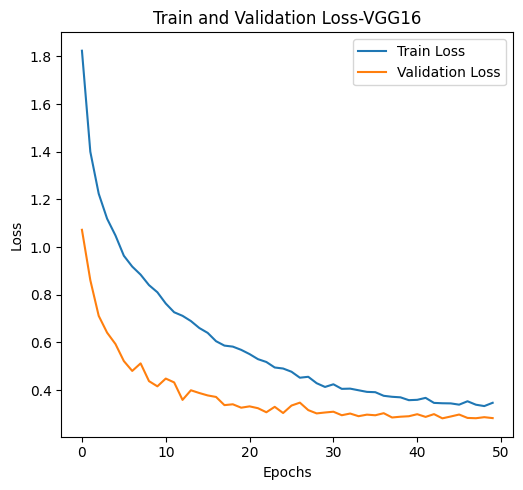

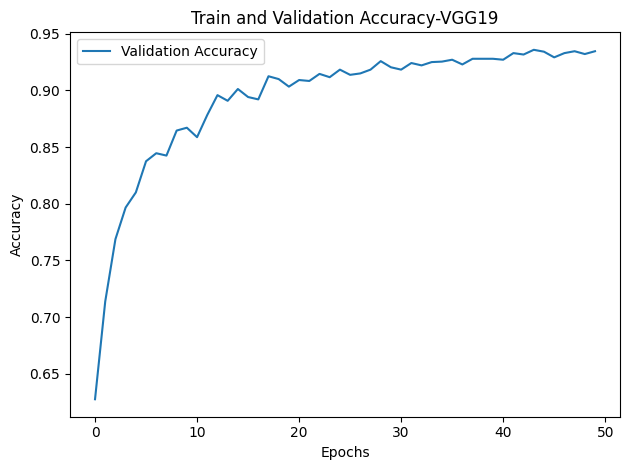

In [ ]:
import matplotlib.pyplot as plt

with open('/content/drive/MyDrive/mushrooms_dataset_cls10/vgg16_run_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)
# Plotting train and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# print(dir(trainer.run_history))
print(loaded_history.keys())
print(loaded_history['train_loss_metric'])
print(loaded_history['eval_loss_epoch'])

# with open('/content/run_history.pkl', 'rb') as f:
#   loaded_history = pickle.load(f)

plt.plot(loaded_history['train_loss_metric'], label="Train Loss")
plt.plot(loaded_history['eval_loss_epoch'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss-VGG16")
plt.legend()
plt.tight_layout()
plt.show()

# Plotting train and validation accuracy
plt.subplot(1, 1, 1)
plt.plot(loaded_history['accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy-VGG19")
plt.legend()

plt.tight_layout()
plt.show()

num_classes: 12, len classes:12


Evaluating:   0%|          | 0/2400 [00:00<?, ?it/s]<ipython-input-16-0233ab803fa9>:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels).to(device)
Evaluating:   0%|          | 6/2400 [00:04<25:53,  1.54it/s]

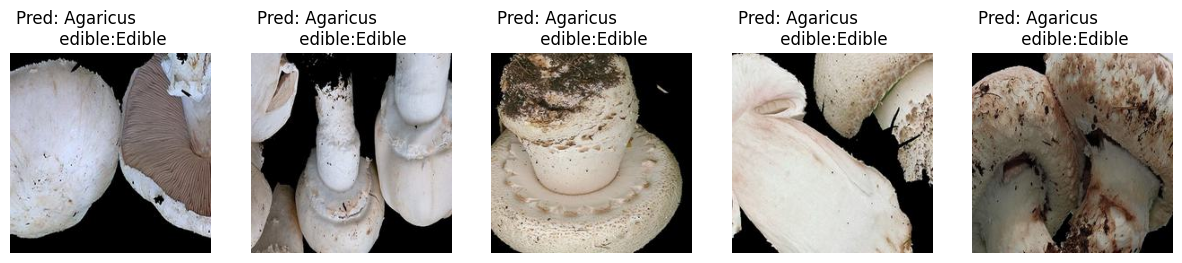

Evaluating: 100%|██████████| 2400/2400 [26:12<00:00,  1.53it/s]


final_accuracy: 0.9358
Confusion Matrix:
 [[190   0   0   0   1   0   1   3   1   0   4   0]
 [  1 190   0   1   1   0   0   0   2   0   4   1]
 [  0   0 183   4   0   1   0   1   3   0   0   8]
 [  4   1   0 177   3   1   3   0   5   0   2   4]
 [  0   5   0   2 175   4   2   2   2   5   2   1]
 [  1   0   1   0   0 196   0   0   0   1   1   0]
 [  0   1   0   2   1   0 193   1   1   0   1   0]
 [  2   0   0   4   4   0   1 187   1   0   1   0]
 [  0   1   0   6   1   0   1   0 179   3   9   0]
 [  0   0   0   0   1   0   1   0   0 197   1   0]
 [  1   1   0   4   0   2   2   1   1   0 188   0]
 [  2   0   2   3   0   0   0   0   2   0   0 191]]
F1 Score: 0.9358
Recall: 0.9358
Precision: 0.9364
Accuracy: 0.9358


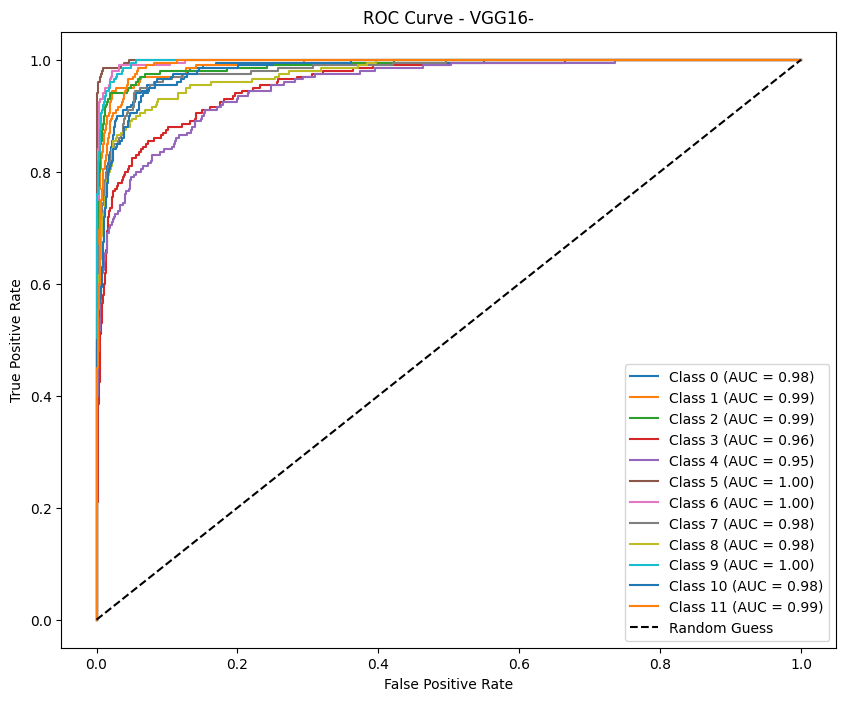

In [ ]:
import torchmetrics
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

def create_eval_datasets(image_size, data_mean, data_std, val_path, label_parser):
    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )
    eval_dataset = timm.data.dataset.ImageDataset(val_path, transform=eval_transforms, class_map=label_parser)

    return eval_dataset

# Define a function to calculate and print all the metrics
def evaluate_model(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # F1 score
    recall = recall_score(y_test, y_pred, average='weighted')  # Recall
    precision = precision_score(y_test, y_pred, average='weighted')  # Precision
    accuracy = accuracy_score(y_test, y_pred)  # Accuracy

    print("Confusion Matrix:\n", cm)
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    return cm


def plot_roc(y_test, y_pred, num_classes, model_name):
  lb = LabelBinarizer()
  plt.figure(figsize=(10, 8))
  # Plot ROC curve for each class
  encoder = OneHotEncoder(sparse_output=False)
  y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1))
  y_pred = encoder.fit_transform(np.array(y_pred).reshape(-1, 1))

  y_test_bin = lb.fit_transform(y_test)
  n_classes = y_pred.shape[1]
  for i in range(n_classes):
      fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, lw=2, label=f'{model_name} - Class {i} (AUC = {roc_auc:.2f})')

def plot_roc2(y_test, y_pred, num_classes, model_name, desc=""):
    plt.figure(figsize=(10, 8))

    encoder = OneHotEncoder(sparse_output=False)
    if y_test.ndim == 1 or y_test.shape[1] == 1:
        one_hot_y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1))
    else:
        one_hot_y_test = y_test

    if y_pred.ndim == 1 or y_pred.shape[1] == 1:
        one_hot_y_pred = encoder.transform(np.array(y_pred).reshape(-1, 1))
    else:
        one_hot_y_pred = y_pred

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(one_hot_y_test[:, i], one_hot_y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}-{desc}")
    plt.legend(loc="lower right")
    plt.show()



#  dataset init
train_path = os.path.join(data_split_drive_path, "train")
val_path = os.path.join(data_split_drive_path, "val")
class_names = sorted([f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))])
assert class_names == sorted([f for f in os.listdir(val_path) if os.path.isdir(os.path.join(val_path, f))])
num_classes = len(class_names)

## init eval model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_eval = timm.create_model('resnet50', pretrained=False, num_classes=10)
model_eval = timm.create_model(
    "vgg16", pretrained=True, num_classes=num_classes)
model_eval = model_eval.to(device)

model_eval.load_state_dict(torch.load('/content/drive/MyDrive/mushrooms_dataset_cls10/pretrainedmodel/vgg16_last_model_weights.pth',map_location=device))
# model_eval.load_state_dict(torch.load('/content/best_model.pt'))
model_eval.eval()

# creat data config
data_config = timm.data.resolve_data_config({}, model=model_eval, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]
image_size = (256, 256)
# Create training and validation datasets
eval_dataset = create_eval_datasets(
    val_path=val_path,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
    label_parser=classname_label_map,
)


print("num_classes: {}, len classes:{}".format(num_classes, len(class_names)))
diplay_pic_num = 5
pic_sample_freq = 2
show_id = 0
fig, axes = plt.subplots(1, diplay_pic_num, figsize=(15, 5))
plt.ion()

accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

y_labels = []
pre_labels = []
pred_probs = []
evaYLabel = "vggg16_y_labels.npy"
evaPreLabel = "vggg16_pre_labels.npy"
evaPreProb = "vggg16_pred_probs.npy"
if not os.path.exists(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaYLabel)):
  with torch.no_grad():
      # for idx, cur_eval_data in enumerate(eval_dataset):
      for idx, cur_eval_data in tqdm(enumerate(eval_dataset), total=len(eval_dataset), desc="Evaluating"):
          # print("image: {}, label :{}".format(images.size(), labels))
          images, labels_orig = cur_eval_data
          label_classname = eval_dataset.filenames()[idx].split("/")[0].split("Tomato___")[-1]
          labels = torch.tensor(labels_orig).to(device)
          images, labels = images.to(device), torch.tensor(labels).to(device)
          images = images.unsqueeze(0)

          outputs = model_eval(images)
          labels = labels.to(torch.int64).reshape(1)

          accuracy_metric.update(outputs.argmax(-1), labels)
          y_labels.append(labels.cpu().item())
          pre_labels.append(outputs.argmax(-1).cpu().item())
          pred_prob = outputs.squeeze().cpu().numpy()
          pred_probs.append(pred_prob)

          ###### visual sample data
          if idx%pic_sample_freq == 0 and show_id<diplay_pic_num:
            image_tmp = Image.open(os.path.join(val_path, eval_dataset.filenames()[idx]))
            axes[show_id].imshow(image_tmp)
            axes[show_id].set_title(f"Pred: {label_classname_map[outputs.argmax(-1).cpu()[0].item()]} \
            \n edible:{label_edible_map[outputs.argmax(-1).cpu()[0].item()]}")
            axes[show_id].axis('off')
            show_id += 1
          if show_id == diplay_pic_num:
            plt.show()
          ##### print("label id:{}, label name: {}, id_map:{}, pred:{}".format(labels_orig, label_classname, id_to_class[labels_orig], outputs.argmax(-1).cpu()[0]))
  #save result to google drive
  with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaYLabel), 'wb') as f:
    np.save(f, np.array(y_labels))
  with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaPreLabel), 'wb') as f:
    np.save(f, np.array(pre_labels))
  with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaPreProb), 'wb') as f:
    np.save(f, np.array(pred_probs))
else:
    with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaYLabel), 'rb') as f:
      y_labels = np.load(f)
    with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaPreLabel), 'rb') as f:
      pre_labels = np.load(f)
    with open(os.path.join("/content/drive/MyDrive/mushrooms_dataset_cls10/", evaPreProb), 'rb') as f:
      pred_probs = np.load(f)

# caculate accuracy
final_accuracy = accuracy_metric.compute()
print(f"final_accuracy: {final_accuracy:.4f}")
evaluate_model(y_labels, pre_labels)
# plot_roc(y_labels, pre_labels, num_classes, 'mushroom_classification')
plot_roc2(np.array(y_labels), np.array(pred_probs), num_classes, "VGG16", desc="")